# AR(1) + GARCH(1,1) Model

This notebook estimates an AR(1) where the residuals follow a GARCH(1,1) model. The results are used to calculate a time-varying (daily) value at risk. 

For learning purposes the code specifies the likelihood function, calls on a optimization function and calculates (numerical) derivatives. For a more automated approach, consider the [ARCHModels.jl](https://github.com/s-broda/ARCHModels.jl) package.

## Load Packages and Extra Functions

In [1]:
using Dates, DelimitedFiles, Statistics, LinearAlgebra, Optim, ForwardDiff

include("jlFiles/printmat.jl")

printwhere (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))           #pyplot() or gr()
gr(size=(480,320))
default(fmt = :svg)

## Loading Data

In [3]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
ymd = round.(Int,xx[:,1])     #YearMonthDay, like 20121231
R   = xx[:,2]                 #returns for the smallest size portfolio
xx  = nothing

y = R[2:end]                           #dependent variable, y(t)
x = [ones(size(R,1)-1) R[1:end-1]]     #regressors, [1, y(t-1)]

dN = Date.(string.(ymd),"yyyymmdd");    #to Julia dates

## The Likelihood Function

Consider a regression equation, where the residual follows a GARCH(1,1) process

$
y_{t}             =x_{t}^{\prime}b+u_{t} \: \text{ with }\: u_{t}=v_{t}\sigma_{t} \: \text{ and }
$

$
\sigma_{t}^{2}    =\omega+\alpha u_{t-1}^{2}+\beta\sigma_{t-1}^{2}.
$

Notice that we require $(\omega,\alpha,\beta)$ to all be positive and $\alpha + \beta < 1$.

If $v_{t}\sim N(0,1)$, then the likelihood function is

$
\ln L=-\frac{T}{2}\ln(2\pi)  
-\frac{1}{2}\sum_{t=1}^{T}\ln\sigma_{t}^{2}-
\frac{1}{2}\sum_{t=1}^{T}\frac{u_{t}^{2}}{\sigma_{t}
^{2}}.
$

The likelihood function of a GARCH(1,1) model is in `garch11LL`.

In [4]:
function garch11LL(par,y,x)

    (T,k) = (size(x,1),size(x,2))

    b                   = par[1:k]             #mean equation, y = x'*b
    (omega,alpha,beta1) = par[k+1:k+3]         #GARCH(1,1) equation: 
                                             #s2(t) = omega + alpha*u(t-1)^2 + beta1*s2(t-1)
    yhat = x*b
    u    = y - yhat
    s2_0 = var(u)

    s2    = zeros(typeof(alpha),T)                 #works with ForwardDiff 
    s2[1] = omega + alpha*s2_0 + beta1*s2_0        #simple, but slow approach
    for t = 2:T                                    #using filter() is perhaps quicker
      s2[t] = omega + alpha*u[t-1]^2 + beta1*s2[t-1]
    end

    LL_t    = -(1/2)*log(2*pi) .- (1/2)*log.(s2) .- (1/2)*(u.^2)./s2
    LL_t[1] = 0.0               #effectively skip the first observation

    LL      = sum(LL_t)

    return LL, LL_t, s2, yhat

end

garch11LL (generic function with 1 method)

## Try the Likelihood Function

In [5]:
par0 = [mean(y),0,var(y)*0.05,0.05,0.90]         #initial parameter guess

(LL,LL_t,s2,yhat) = garch11LL(par0,y,x)          #just testing the log lik

printlnPs("Value of log-likelihood fn at starting guess: ",LL)

Value of log-likelihood fn at starting guess:  -9231.913


## Maximize the Likelihood Function

In [6]:
lower = [-Inf,-0.9999,0,0,0]        #upper and lower bounds on the parameters: b0,b1,omega,alpha,beta
upper = [Inf,0.9999,Inf,1,1]

Sol = optimize(par->-garch11LL(par,y,x)[1],lower,upper,par0)   #minimize -LL

parHat = Optim.minimizer(Sol)          #extract the optimal solution 

printblue("Parameter estimates:")
rowNames = ["b₀","b₁","ω","α","β"]
printTable(parHat,["coef"],rowNames)

Parameter estimates:
        coef
b₀     0.049
b₁     0.256
ω      0.014
α      0.162
β      0.824



## Standard Errors of the Estimates

MLE is typically asymptotically normally distributed

$
\sqrt{T}(\hat{\theta}-\theta)  \rightarrow^{d}N(0,V) \: \text{, where } \: V=I(\theta)^{-1}\text{ with }
$

$
I(\theta) =-\text{E}\frac{\partial^{2}\ln L_t}{\partial\theta\partial\theta^{\prime}}
$

where $\ln L_t$  is the contribution of period $t$ to the likelihood function and $I(\theta)$ is the information matrix.

The code below calculates numerical derivatives.  


Alternatively, we can use the outer product of the gradients to calculate the
information matrix as

$
J(\theta)=\text{E}\left[  \frac{\partial\ln L_t}{\partial\theta
}\frac{\partial\ln L_t}{\partial\theta^{\prime}}\right]
$

We could also use the "sandwich" estimator

$
V=I(\theta)^{-1}J(\theta)I(\theta)^{-1}.
$

### Std from Hessian

In [7]:
T = size(y,1)                    #finding std(coefs) by inverse of information matrix

Ia         = -ForwardDiff.hessian(par->mean(garch11LL(par,y,x)[2]),parHat)
Ia         = (Ia+Ia')/2              #to guarantee symmetry
vcv        = inv(Ia)/T
std_parHat = sqrt.(diag(vcv))

printblue("std from Hessian:")
printTable(std_parHat,["Std"],rowNames)

std from Hessian:
         Std
b₀     0.006
b₁     0.012
ω      0.001
α      0.009
β      0.009



### Std from Gradient and Sandwich

In [8]:
LLgrad = ForwardDiff.jacobian(par->garch11LL(par,y,x)[2],parHat)   #T x length(par) matrix, T gradients
J           = LLgrad'LLgrad/T
vcv         = inv(J)/T
stdb_parHat = sqrt.(diag(vcv))                          #std from gradients

vcv         = inv(Ia) * J * inv(Ia)/T
stdc_parHat = sqrt.(diag(vcv))                          #std from sandwich

printblue("GARCH parameter estimates and 3 different standard errors:")
xx = [parHat std_parHat stdb_parHat stdc_parHat]
printTable(xx,["coef","Std hessian","Std gradient","Std sandwich"],rowNames,width=14)

GARCH parameter estimates and 3 different standard errors:
            coef   Std hessian  Std gradient  Std sandwich
b₀         0.049         0.006         0.006         0.007
b₁         0.256         0.012         0.012         0.013
ω          0.014         0.001         0.001         0.003
α          0.162         0.009         0.005         0.020
β          0.824         0.009         0.005         0.019



# Value at Risk

calculated by assuming conditional (time-varying) normality,

$
\text{VaR} = -(\mu_t - 1.645 \sigma_t),
$

where 
$\mu_t$ are the predictions from the estimated mean equation ($x_t'b$) and $\sigma_t$ from the GARCH(1,1) model.

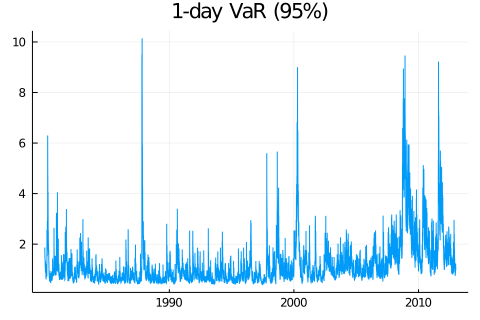

In [9]:
(σ²,μ) = garch11LL(parHat,y,x)[3:4]         #get the fitted values of the σ²- and μ-vectors
VaR95  = -(μ - 1.645*sqrt.(σ²))


xTicksLoc = [Date(1990),Date(2000),Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN[2:end],VaR95,
           xticks = (xTicksLoc,xTicksLab),
           legend = false,
           title = "1-day VaR (95%)" )
display(p1)

In [10]:
CovRatio = mean((-y) .>= VaR95)             #coverage ratio for VaR
printlnPs("Coverage ratio for VaR(95%): ",CovRatio)

Coverage ratio for VaR(95%):      0.058
